## Illustration of good, bad and useless practices when collinearity is encountered

In [1]:
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nilearn.glm import expression_to_contrast_vector


In [2]:
figure_output_path = '/Users/jeanettemumford/Desktop'

In [3]:
def make_step_desplot(
    desmat_left,
    desmat_right,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_left,
    frame_times_right,
    figure_path=None,
    conv=False,
    add_ylim=0.5,
    linestyle_left=None,
    linecolor_left=None,
    linestyle_right=None,
    linecolor_right=None,
    alpha_right=None,
):
    if linestyle_left is None:
        linestyle_left = ['-'] * desmat_left.shape[1]
    if linecolor_left is None:
        linecolor_left = plt.get_cmap('tab10').colors[: desmat_left.shape[1]]
    if linestyle_right is None:
        linestyle_right = ['-'] * desmat_right.shape[1]
    if linecolor_right is None:
        linecolor_right = plt.get_cmap('tab10').colors[: desmat_right.shape[1]]
    if alpha_right is None:
        alpha_right = [1] * desmat_right.shape[1]
    alpha_left = [1] * desmat_left.shape[1]
    designs = {name_left: desmat_left, name_right: desmat_right}
    subtitles = [subtitle_left, subtitle_right]
    fig, axes = plt.subplots(2, 1, figsize=(3, 5.5))
    for i, name in enumerate(designs.keys()):
        frame_times_loop = frame_times_left if i == 0 else frame_times_right
        linecolor_loop = linecolor_left if i == 0 else linecolor_right
        linestyle_loop = linestyle_left if i == 0 else linestyle_right
        alpha_loop = alpha_left if i == 0 else alpha_right
        columns = designs[name].drop(columns=['constant']).columns
        for line_num, column in enumerate(columns):
            if conv:
                axes[i].plot(
                    frame_times_loop,
                    designs[name][column],
                    label=column,
                    linewidth=2,
                    linestyle=linestyle_loop[line_num],
                    color=linecolor_loop[line_num],
                    alpha=alpha_loop[line_num],
                )
            else:
                axes[i].step(
                    frame_times_loop,
                    designs[name][column],
                    label=column,
                    linewidth=2,
                    where='post',
                )
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_title(name, fontsize=12, pad=18)
        axes[i].text(
            0.5,
            1.02,
            subtitles[i],
            transform=axes[i].transAxes,
            fontsize=10,
            ha='center',
        )
        axes[i].legend(loc='upper left', fontsize=8, frameon=False)
        axes[i].set_ylim(axes[i].get_ylim()[0], axes[i].get_ylim()[1] + add_ylim)
    plt.tight_layout()
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

In [4]:
def est_contrast_vifs(desmat, contrasts):
    """
    IMPORTANT: This is only valid to use on design matrices where each regressor represents a condition vs baseline
     or if a parametrically modulated regressor is used the modulator must have more than 2 levels.  If it is a 2 level modulation,
     split the modulation into two regressors instead.

    Calculates VIF for contrasts based on the ratio of the contrast variance estimate using the
    true design to the variance estimate where between condition correaltions are set to 0
    desmat : pandas DataFrame, design matrix
    contrasts : dictionary of contrasts, key=contrast name,  using the desmat column names to express the contrasts
    returns: pandas DataFrame with VIFs for each contrast
    """
    desmat_copy = desmat.copy()
    # find location of constant regressor and remove those columns (not needed here)
    desmat_copy = desmat_copy.loc[
        :, (desmat_copy.nunique() > 1) | (desmat_copy.isnull().any())
    ]
    # Scaling stabilizes the matrix inversion
    nsamp = desmat_copy.shape[0]
    desmat_copy = (desmat_copy - desmat_copy.mean()) / (
        (nsamp - 1) ** 0.5 * desmat_copy.std()
    )
    vifs_contrasts = {}
    for contrast_name, contrast_string in contrasts.items():
        contrast_cvec = expression_to_contrast_vector(
            contrast_string, desmat_copy.columns
        )
        true_var_contrast = (
            contrast_cvec
            @ np.linalg.pinv(desmat_copy.transpose() @ desmat_copy)
            @ contrast_cvec.transpose()
        )
        # The folllowing is the "best case" scenario because the between condition regressor dot products are set to 0
        best_var_contrast = (
            contrast_cvec
            @ np.linalg.pinv(
                np.multiply(
                    desmat_copy.transpose() @ desmat_copy,
                    np.identity(desmat_copy.shape[1]),
                )
            )
            @ contrast_cvec.transpose()
        )
        vifs_contrasts[contrast_name] = true_var_contrast / best_var_contrast
    return vifs_contrasts

# Panel A: Orthogonalization example

In [5]:
onset_max = 50
onsets_a = np.arange(5, onset_max, 5)
onset_b = onsets_a + 1

onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['face'] * len(onsets_a) + ['house'] * len(onset_b))
duration = np.ones_like(onsets)

trial_type_modulation = np.array(['face-house'] * len(onsets) + ['trial'] * len(onsets))
duration_modulation = np.concatenate([duration, duration])
onsets_modulation = np.concatenate([onsets, onsets])
modulation = np.concatenate(
    [np.where(trial_type == 'face', 1, -1), np.ones(len(trial_type))]
)

events_a_b_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_a_b_modulation = pd.DataFrame(
    {
        'onset': onsets_modulation,
        'trial_type': trial_type_modulation,
        'duration': duration_modulation,
        'modulation': modulation,
    }
)
frame_times = np.arange(0, onset_max + 5, 1)

events_a_b_separate_one_trial = events_a_b_separate[events_a_b_separate['onset'] < 10]
frame_times_one_trial = frame_times[frame_times < 25]
original_design_matrix_one_trial = make_first_level_design_matrix(
    frame_times_one_trial,
    events=events_a_b_separate_one_trial,
    hrf_model='spm',
    drift_model=None,
)

original_design_matrix = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model='spm', drift_model=None
)


original_design_matrix_neural = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model=None, drift_model=None
)

events_a_b_modulation_one_trial = events_a_b_modulation[
    events_a_b_modulation['onset'] < 10
]
modulated_design_matrix_one_trial = make_first_level_design_matrix(
    frame_times_one_trial,
    events=events_a_b_modulation_one_trial,
    hrf_model='spm',
    drift_model=None,
)

modulated_design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_modulation,
    hrf_model='spm',
    drift_model=None,
)

modulated_design_matrix_neural = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_modulation,
    hrf_model=None,
    drift_model=None,
)


[check_events] A 'modulation' column was found in the given events data and is used.
[check_events] A 'modulation' column was found in the given events data and is used.
[check_events] A 'modulation' column was found in the given events data and is used.


In [6]:
modulated_design_matrix_one_trial['trial'] = (
    modulated_design_matrix_one_trial['trial'] / 5
)

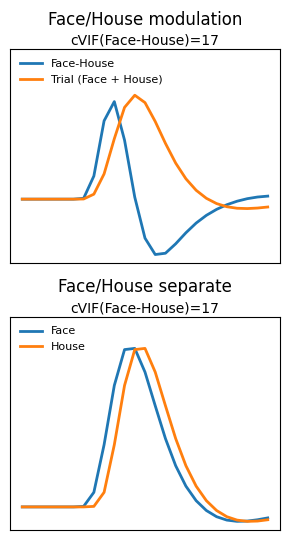

In [7]:
original_design_matrix_rename = original_design_matrix_one_trial.rename(
    columns={'face': 'Face', 'house': 'House'}
)

modulated_design_matrix_rename = modulated_design_matrix_one_trial.rename(
    columns={'face-house': 'Face-House', 'trial': 'Trial (Face + House)'}
)

vif_orig = est_contrast_vifs(original_design_matrix, {'Face-House': 'face - house'})
vif_modulated = est_contrast_vifs(original_design_matrix, {'Face-House': 'face-house'})

name_left = f'Face/House separate'
subtitle_left = f'cVIF(Face-House)={vif_orig["Face-House"]:.0f}'
name_right = f'Face/House modulation'
subtitle_right = f'cVIF(Face-House)={vif_modulated["Face-House"]:.0f}'
fig_path = f'{figure_output_path}/orthog_conv.pdf'
make_step_desplot(
    modulated_design_matrix_rename,
    original_design_matrix_rename,
    name_right,
    name_left,
    subtitle_right,
    subtitle_left,
    frame_times_one_trial,
    frame_times_one_trial,
    figure_path=fig_path,
    conv=True,
    add_ylim=0.03,
)

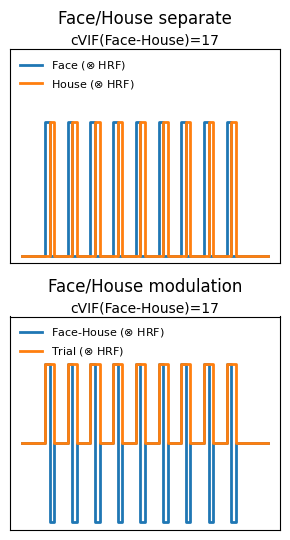

In [8]:
# \n VIF(Face-House)={vif_orig["Face-House"]:.0f}
original_design_matrix_neural_rename = original_design_matrix_neural.rename(
    columns={'face': r'Face ($\otimes$ HRF)', 'house': r'House ($\otimes$ HRF)'}
)

modulated_design_matrix_neural_rename = modulated_design_matrix_neural.rename(
    columns={
        'face-house': r'Face-House ($\otimes$ HRF)',
        'trial': r'Trial ($\otimes$ HRF)',
    }
)

vif_orig = est_contrast_vifs(original_design_matrix, {'Face-House': 'face - house'})
vif_modulated = est_contrast_vifs(original_design_matrix, {'Face-House': 'face-house'})

name_left = f'Face/House separate'
subtitle_left = f'cVIF(Face-House)={vif_orig["Face-House"]:.0f}'
name_right = f'Face/House modulation'
subtitle_right = f'cVIF(Face-House)={vif_modulated["Face-House"]:.0f}'
fig_path = f'{figure_output_path}/testfig.pdf'
make_step_desplot(
    original_design_matrix_neural_rename,
    modulated_design_matrix_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## Panel B, With/without derivative panel

In [9]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 2
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['face'] * len(onsets_a) + ['house'] * len(onset_b))
duration = np.ones_like(onsets)

events_a_b_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)

events_a_b_separate_one_trial = events_a_b_separate[events_a_b_separate['onset'] < 5]

frame_times = np.arange(0, onset_max, 1)

frame_times_one_trial = frame_times[frame_times < 15]

des_with_deriv_one_trial = make_first_level_design_matrix(
    frame_times_one_trial,
    events=events_a_b_separate_one_trial,
    hrf_model='spm + derivative',
    drift_model=None,
)

des_with_deriv = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_separate,
    hrf_model='spm + derivative',
    drift_model=None,
)

des_no_deriv_one_trial = make_first_level_design_matrix(
    frame_times_one_trial,
    events=events_a_b_separate_one_trial,
    hrf_model='spm',
    drift_model=None,
)

des_no_deriv = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model='spm', drift_model=None
)

des_with_deriv_neural = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_separate,
    hrf_model=None,
    drift_model=None,
)

des_no_deriv_neural = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model=None, drift_model=None
)

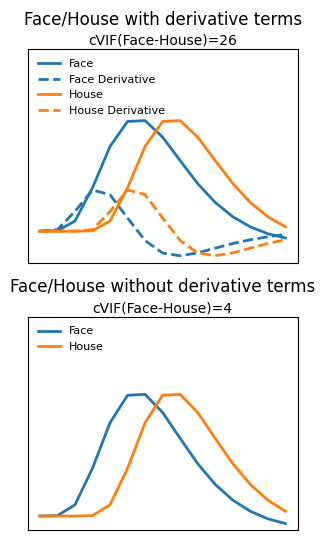

In [10]:
des_with_deriv_rename = des_with_deriv_one_trial.rename(
    columns={
        'face': 'Face',
        'house': 'House',
        'face_derivative': 'Face Derivative',
        'house_derivative': 'House Derivative',
    }
)

des_no_deriv_rename = des_no_deriv_one_trial.rename(
    columns={'face': 'Face', 'house': 'House'}
)

vif_deriv_yes = est_contrast_vifs(des_with_deriv, {'Face-House': 'face - house'})
vif_deriv_no = est_contrast_vifs(des_no_deriv, {'Face-House': 'face-house'})

name_left = f'Face/House with derivative terms'
subtitle_left = f'cVIF(Face-House)={vif_deriv_yes["Face-House"]:.0f}'
name_right = f'Face/House without derivative terms'
subtitle_right = f'cVIF(Face-House)={vif_deriv_no["Face-House"]:.0f}'
linecolor_left = [plt.get_cmap('tab10').colors[0]] * 2 + [
    plt.get_cmap('tab10').colors[1]
] * 2
linestyle_left = ['-', '--', '-', '--']
linecolor_right = plt.get_cmap('tab10').colors[:2]
linestyle_right = ['-', '-']
fig_path = f'{figure_output_path}/deriv_conv.pdf'
make_step_desplot(
    des_with_deriv_rename,
    des_no_deriv_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_one_trial,
    frame_times_one_trial,
    figure_path=fig_path,
    conv=True,
    add_ylim=0.12,
    linestyle_left=linestyle_left,
    linecolor_left=linecolor_left,
    linestyle_right=linestyle_right,
    linecolor_right=linecolor_right,
)

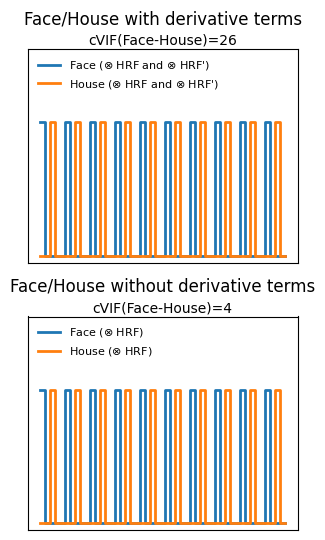

In [11]:
des_with_deriv_neural_rename = des_with_deriv_neural.rename(
    columns={
        'face': r"Face ($\otimes$ HRF and $\otimes$ HRF')",
        'house': r"House ($\otimes$ HRF and $\otimes$ HRF')",
    }
)

des_no_deriv_neural_rename = des_no_deriv_neural.rename(
    columns={'face': r'Face ($\otimes$ HRF)', 'house': r'House ($\otimes$ HRF)'}
)

vif_deriv_yes = est_contrast_vifs(des_with_deriv, {'Face-House': 'face - house'})
vif_deriv_no = est_contrast_vifs(des_no_deriv, {'Face-House': 'face-house'})

name_left = f'Face/House with derivative terms'
subtitle_left = f'cVIF(Face-House)={vif_deriv_yes["Face-House"]:.0f}'
name_right = f'Face/House without derivative terms'
subtitle_right = f'cVIF(Face-House)={vif_deriv_no["Face-House"]:.0f}'
fig_path = f'{figure_output_path}/testfig2.pdf'
make_step_desplot(
    des_with_deriv_neural_rename,
    des_no_deriv_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## Panel C, Combining stimuli

In [12]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 0.5
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
trial_type_cueprobe = np.array(['cue+probe'] * len(onsets_a))
duration_cue_probe = np.ones_like(onsets_a) * 2.5

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_cue_probe_together = pd.DataFrame(
    {
        'onset': onsets_a,
        'trial_type': trial_type_cueprobe,
        'duration': duration_cue_probe,
    }
)

events_cue_probe_separate_trial = events_cue_probe_separate[
    events_cue_probe_separate['onset'] < 1
]
events_cue_probe_together_trial = events_cue_probe_together[
    events_cue_probe_together['onset'] < 1
]


frame_times = np.arange(0, onset_max, 1)

frame_times_trial = frame_times[frame_times < 20]

des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_cueprobe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_together,
    hrf_model='spm',
    drift_model=None,
)

des_cue_and_probe_onetrial = make_first_level_design_matrix(
    frame_times_trial,
    events=events_cue_probe_separate_trial,
    hrf_model='spm',
    drift_model=None,
)

des_cueprobe_onetrial = make_first_level_design_matrix(
    frame_times_trial,
    events=events_cue_probe_together_trial,
    hrf_model='spm',
    drift_model=None,
)

des_cue_and_probe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model=None,
    drift_model=None,
)

des_cueprobe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_together,
    hrf_model=None,
    drift_model=None,
)

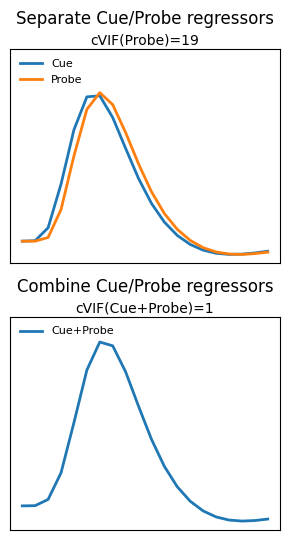

In [13]:
des_cue_and_probe_rename = des_cue_and_probe_onetrial.rename(
    columns={'cue': 'Cue', 'probe': 'Probe'}
)

des_cueprobe_rename = des_cueprobe_onetrial.rename(columns={'cue+probe': 'Cue+Probe'})

vif_cueprobe = est_contrast_vifs(des_cueprobe, {'cue+probe': 'cue+probe'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'Probe': 'probe'})

name_left = f'Separate Cue/Probe regressors'
subtitle_left = f'cVIF(Probe)={vif_cue_and_probe["Probe"]:.0f}'
name_right = f'Combine Cue/Probe regressors'
subtitle_right = f'cVIF(Cue+Probe)={vif_cueprobe["cue+probe"]:.0f}'
fig_path = f'{figure_output_path}/cue_probe_sum.pdf'
make_step_desplot(
    des_cue_and_probe_rename,
    des_cueprobe_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_trial,
    frame_times_trial,
    figure_path=fig_path,
    conv=True,
    add_ylim=0.05,
)

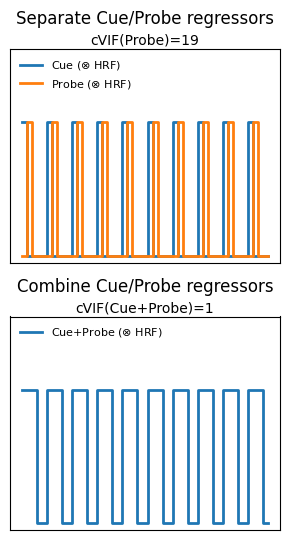

In [14]:
des_cue_and_probe_neural_rename = des_cue_and_probe_neural.rename(
    columns={'cue': r'Cue ($\otimes$ HRF)', 'probe': r'Probe ($\otimes$ HRF)'}
)

des_cueprobe_neural_rename = des_cueprobe_neural.rename(
    columns={'cue+probe': r'Cue+Probe ($\otimes$ HRF)'}
)

vif_cueprobe = est_contrast_vifs(des_cueprobe, {'cue+probe': 'cue+probe'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'Probe': 'probe'})

name_left = f'Separate Cue/Probe regressors'
subtitle_left = f'cVIF(Probe)={vif_cue_and_probe["Probe"]:.0f}'
name_right = f'Combine Cue/Probe regressors'
subtitle_right = f'cVIF(Cue+Probe)={vif_cueprobe["cue+probe"]:.0f}'
fig_path = f'{figure_output_path}/testfig3.pdf'
make_step_desplot(
    des_cue_and_probe_neural_rename,
    des_cueprobe_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## Panel D, Using True durations

In [15]:
onset_max = 50
dur_val = 2
onsets_a = np.arange(0, onset_max, dur_val * 2)
onset_b = onsets_a + dur_val
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets) * dur_val
duration_impulse = np.ones_like(onsets) * 0.00001
duration_impulse1 = np.ones_like(onsets) * 0.501

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_impulse = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration_impulse}
)

events_impulse1 = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration_impulse1}
)

events_cue_probe_separate_trial = events_cue_probe_separate[
    events_cue_probe_separate['onset'] <= dur_val
]
events_impulse_trial = events_impulse[events_impulse['onset'] <= dur_val]

frame_times = np.arange(0, onset_max, 1)
frame_times_trial = frame_times[frame_times < 20]

des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_impulse = make_first_level_design_matrix(
    frame_times, events=events_impulse, hrf_model='spm', drift_model=None
)

des_cue_and_probe_trial = make_first_level_design_matrix(
    frame_times_trial,
    events=events_cue_probe_separate_trial,
    hrf_model='spm',
    drift_model=None,
)

des_impulse_trial = make_first_level_design_matrix(
    frame_times_trial, events=events_impulse_trial, hrf_model='spm', drift_model=None
)

des_cue_and_probe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model=None,
    drift_model=None,
)

des_impulse_neural = make_first_level_design_matrix(
    frame_times, events=events_impulse1, hrf_model=None, drift_model=None
)

/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_simulations/.venv/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


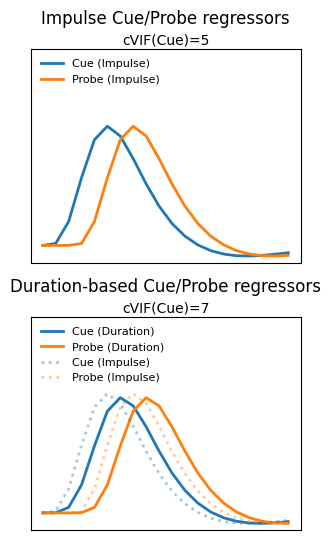

In [16]:
des_cue_and_probe_rename = des_cue_and_probe_trial.rename(
    columns={'cue': 'Cue (Duration)', 'probe': 'Probe (Duration)'}
)

des_impulse_rename = (
    des_impulse_trial.rename(
        columns={'cue': 'Cue (Impulse)', 'probe': 'Probe (Impulse)'}
    )
    * 100
)

des_cue_and_probe_rename['Cue (Impulse)'] = des_impulse_rename['Cue (Impulse)']
des_cue_and_probe_rename['Probe (Impulse)'] = des_impulse_rename['Probe (Impulse)']

linecolor_right = plt.get_cmap('tab10').colors[:2] * 2
linestyle_right = ['-', '-', ':', ':']
alpha_right = [1, 1, 0.4, 0.4]

vif_impulse = est_contrast_vifs(des_impulse, {'cue': 'cue'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'cue': 'cue'})

name_left = f'Impulse Cue/Probe regressors'
subtitle_left = f'cVIF(Cue)={vif_impulse["cue"]:.0f}'
name_right = f'Duration-based Cue/Probe regressors'
subtitle_right = f'cVIF(Cue)={vif_cue_and_probe["cue"]:.0f}'
fig_path = f'{figure_output_path}/cue_probe_impulse.pdf'
make_step_desplot(
    des_impulse_rename,
    des_cue_and_probe_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_trial,
    frame_times_trial,
    figure_path=fig_path,
    conv=True,
    add_ylim=0.25,
    linestyle_right=linestyle_right,
    linecolor_right=linecolor_right,
    alpha_right=alpha_right,
)

In [17]:
def make_df_step(desmat, var_name1, var_name2):
    desmat = des_impulse_neural.copy()
    desmat['frame_times'] = frame_times

    rows = []
    for _, row in desmat.iterrows():
        rows.append(row)
        if row[var_name1] == 1 or row[var_name2] == 1:
            new_row = row.copy()
            new_row[var_name1] = 0
            new_row[var_name2] = 0
            rows.append(new_row)

    desmat_new = pd.DataFrame(rows).reset_index(drop=True)
    return desmat_new


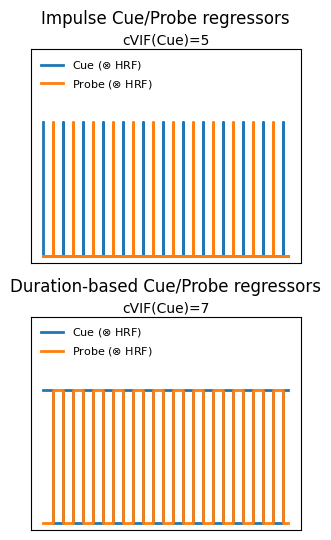

In [18]:
des_cue_and_probe_neural_rename = des_cue_and_probe_neural.rename(
    columns={'cue': r'Cue ($\otimes$ HRF)', 'probe': r'Probe ($\otimes$ HRF)'}
)

des_impulse_step = make_df_step(des_impulse_neural, 'cue', 'probe')
des_impulse_neural_rename = des_impulse_step.rename(
    columns={'cue': r'Cue ($\otimes$ HRF)', 'probe': r'Probe ($\otimes$ HRF)'}
)
frame_times_impulse = des_impulse_neural_rename['frame_times']
des_impulse_neural_rename = des_impulse_neural_rename.drop(columns=['frame_times'])

vif_impulse = est_contrast_vifs(des_impulse, {'cue': 'cue'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'cue': 'cue'})

name_left = f'Impulse Cue/Probe regressors'
subtitle_left = f'cVIF(Cue)={vif_impulse["cue"]:.0f}'
name_right = f'Duration-based Cue/Probe regressors'
subtitle_right = f'cVIF(Cue)={vif_cue_and_probe["cue"]:.0f}'
fig_path = f'{figure_output_path}/testfig4.pdf'
make_step_desplot(
    des_impulse_neural_rename,
    des_cue_and_probe_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_impulse,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## Panel E, Omitting task regressors

In [19]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 1
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
trial_type_cue = np.array(['cue'] * len(onsets_a))
duration_cue = np.ones_like(onsets_a) * 1

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_no_probe = pd.DataFrame(
    {
        'onset': onsets_a,
        'trial_type': trial_type_cue,
        'duration': duration_cue,
    }
)

events_cue_probe_separate_trial = events_cue_probe_separate[
    events_cue_probe_separate['onset'] < 2
]
events_no_probe_trial = events_no_probe[events_no_probe['onset'] < 2]

frame_times = np.arange(0, onset_max, 1)
frame_times_trial = frame_times[frame_times < 15]

des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_no_probe = make_first_level_design_matrix(
    frame_times, events=events_no_probe, hrf_model='spm', drift_model=None
)

des_cue_and_probe_trial = make_first_level_design_matrix(
    frame_times_trial,
    events=events_cue_probe_separate_trial,
    hrf_model='spm',
    drift_model=None,
)

des_no_probe_trial = make_first_level_design_matrix(
    frame_times_trial, events=events_no_probe_trial, hrf_model='spm', drift_model=None
)

des_cue_and_probe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model=None,
    drift_model=None,
)

des_no_probe_neural = make_first_level_design_matrix(
    frame_times, events=events_no_probe, hrf_model=None, drift_model=None
)

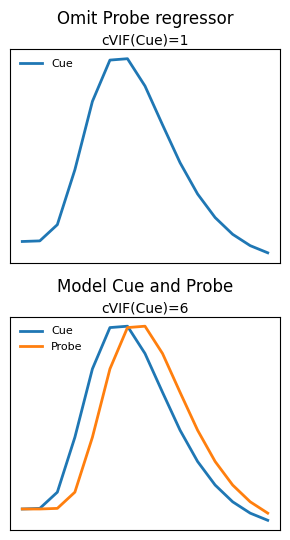

In [20]:
des_cue_and_probe_rename = des_cue_and_probe_trial.rename(
    columns={'cue': 'Cue', 'probe': 'Probe'}
)

des_no_probe_rename = des_no_probe_trial.rename(columns={'cue': 'Cue'})

vif_no_probe = est_contrast_vifs(des_no_probe, {'cue': 'cue'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'cue': 'cue'})

name_left = f'Omit Probe regressor'
subtitle_left = f'cVIF(Cue)={vif_no_probe["cue"]:.0f}'
name_right = f'Model Cue and Probe'
subtitle_right = f'cVIF(Cue)={vif_cue_and_probe["cue"]:.0f}'
fig_path = f'{figure_output_path}/omit_regressor.pdf'
make_step_desplot(
    des_no_probe_rename,
    des_cue_and_probe_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_trial,
    frame_times_trial,
    figure_path=fig_path,
    conv=True,
    add_ylim=0,
)

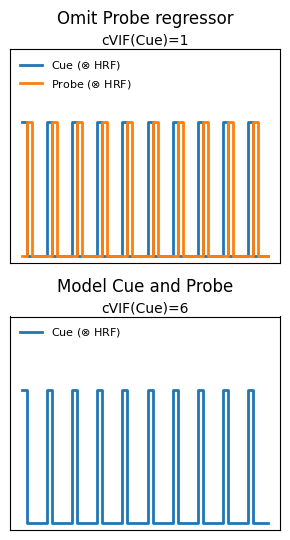

In [21]:
des_cue_and_probe_neural_rename = des_cue_and_probe_neural.rename(
    columns={'cue': r'Cue ($\otimes$ HRF)', 'probe': r'Probe ($\otimes$ HRF)'}
)

des_no_probe_neural_rename = des_no_probe_neural.rename(
    columns={'cue': r'Cue ($\otimes$ HRF)'}
)

vif_no_probe = est_contrast_vifs(des_no_probe, {'cue': 'cue'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'cue': 'cue'})

name_left = f'Omit Probe regressor'
subtitle_left = f'cVIF(Cue)={vif_no_probe["cue"]:.0f}'
name_right = f'Model Cue and Probe'
subtitle_right = f'cVIF(Cue)={vif_cue_and_probe["cue"]:.0f}'
fig_path = f'{figure_output_path}/testfig5.pdf'
make_step_desplot(
    des_cue_and_probe_neural_rename,
    des_no_probe_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)